# AQI Data Acquisition
This notebook contains the code for reading in the historical AQI data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.
Specifically, this analyses makes API requests for AQI data from Cleveland county (home to Norman), and nearby Oklahoma county (home to Oklahoma City) in Oklahoma. 

## License
This notebook was adapted from an example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

## Importing Libraries

In [1]:
import json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#
#    The 'requests' module is a distribution module for making web requests.
import requests

## Defining Constants for the API Call

In [2]:
#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



## Creating a Signup Request
Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key. I have commented out this code and omitted my username and API key, if you would like to rerun this code, you will need to generate your own signup request and get a new API key

In [3]:
# #
# #    This implements the sign-up request. The parameters are standardized so that this function definition matches
# #    all of the others. However, the easiest way to call this is to simply call this function with your preferred
# #    email address.
# #
# def request_signup(email_address = None,
#                    endpoint_url = API_REQUEST_URL, 
#                    endpoint_action = API_ACTION_SIGNUP, 
#                    request_template = AQS_REQUEST_TEMPLATE,
#                    headers = None):
    
#     # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
#     if email_address:
#         request_template['email'] = email_address        
    
#     if not request_template['email']: 
#         raise Exception("Must supply an email address to call 'request_signup()'")

#     if '@' not in request_template['email']: 
#         raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

#     # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
#     request_url = endpoint_url+endpoint_action.format(**request_template)
        
#     # make the request
#     try:
#         # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
#         # during the request processing - throttling is always a good practice with a free data source
#         if API_THROTTLE_WAIT > 0.0:
#             time.sleep(API_THROTTLE_WAIT)
#         response = requests.get(request_url, headers=headers)
#         json_response = response.json()
#     except Exception as e:
#         print(e)
#         json_response = None
#     return json_response

#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
# print("Requesting SIGNUP ...")
# USERNAME = "USER EMAIL"
# response = request_signup(USERNAME)
# print(json.dumps(response,indent=4))


In [ ]:
# USERNAME = 
# APIKEY = 

## Extract a list of groups of available sensors

In [5]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

Here, we identify the class of sensors called "AQI Pollutants", in which we will next extract the sensor IDs that make up that group

In [6]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

In our analysis, we will investigate both gaseous and particulate values.

In [7]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
# #   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
# #
# #   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"


#   
#

PM25_PARTICULATES = "88101"
PM10_PARTICULATES = "88102"

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. 

We can extract the FIPS number associated with Norman, OK, which is located in Cleveland county, which we identify is 40027, and make a list request for sensors located in that region.

In [8]:
CITY_LOCATIONS = {
    'norman' :       {'city'   : 'norman',
                       'county' : 'Cleveland',
                       'state'  : 'Oklahoma',
                       'fips'   : '40027',
                       'latlon' : [35.24, -97.35]}
}

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['norman']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['norman']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0040",
        "value_represented": null
    },
    {
        "code": "0043",
        "value_represented": null
    },
    {
        "code": "0044",
        "value_represented": null
    },
    {
        "code": "0049",
        "value_represented": "MOORE WATER TOWER"
    }
]


Here, we see that there are four different monitoring locations in Cleveland County. However, upon digging deeper, 0044 and 0049 are the only ones with some amount of data, with 0049 having lots of historical gaseous metrics, so we will use 0049 for gaseous AQI extraction. On the particulate side, of these 4, only 0049 has any amount of meaningful data, and it only goes back to 2013. Therefore, we will next use the bounding box technique to look for sensors with more particulate data a bit beyond Cleveland County.

In [9]:
LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
#
#   Compute rough estimates for a bounding box around a given place
#   The bounding box is scaled in 50 mile increments. That is, the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#
def bounding_latlon(place=None,scale=1.0):
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]

#Define a new function to extract monitors from a bounding box
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_MONITORS_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS    # same particulate request as the one abover

#   100 mile box - roughly within 50 miles of the location
bbox = bounding_latlon(CITY_LOCATIONS['norman'],scale=2.0)

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

#
#   we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data, begin_date="19610101", end_date="20211231",
                            endpoint_action = API_ACTION_MONITORS_BOX)

if response["Header"][0]['status'] == "Success":
    for data in response['Data']:
        #if data['site_number'] == "0035":
        if data['county_code'] == "027":
            print(json.dumps(data,indent=4))
# else:
#     print(json.dumps(response,indent=4))

{
    "state_code": "40",
    "county_code": "027",
    "site_number": "0044",
    "parameter_code": "42101",
    "poc": 1,
    "parameter_name": "Carbon monoxide",
    "open_date": "1982-01-01",
    "close_date": "1987-12-01",
    "concurred_exclusions": null,
    "dominant_source": null,
    "measurement_scale": null,
    "measurement_scale_def": null,
    "monitoring_objective": "UNKNOWN",
    "last_method_code": "011",
    "last_method_description": "INSTRUMENTAL - NONDISPERSIVE INFRARED",
    "last_method_begin_date": "1982-01-01",
    "naaqs_primary_monitor": null,
    "qa_primary_monitor": null,
    "monitor_type": null,
    "networks": null,
    "monitoring_agency_code": "0812",
    "monitoring_agency": "Oklahoma Dept. Of Environmental Quality Air Quality Division",
    "si_id": 12815,
    "latitude": 35.337008,
    "longitude": -97.479758,
    "datum": "WGS84",
    "lat_lon_accuracy": 0.0,
    "elevation": 369.0,
    "probe_height": 5.0,
    "pl_probe_location": null,
    "loc

Inspecting the output from this bounding box, we can identify one site, "0035", located on the Cnetral Fire Station in nearby Oklahoma City (~20 Miles away), that has data for PM10 going back from 1985, and PM2.5 going back to 1999. Therefore, we will use the partiuclate data from this location in the rest of our analysis.

## Extract the daily historical AQI sensor data 
The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

Below, we first define a function "request_daily_summary" to actually make the API call, and then another function "extract_summary_from_response" to format the output of the response into a much more readable format.

In [11]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


Execute the call for the Central Fire Station in Oklahoma City, first for the Particulates and then for the Gasses. Note that here we will also be filtering to only dates that occur during fires season (May 1 to October 31) (analysis technique in collaboration with Sid Gurajala).

In [ ]:
request_data['state'] = 40 #Oklahoma

#Define the years of analysis
years = list(range(1961, 2022))
yearly_average_aqi = {}

#Create an empty dictionary to store the extracted results for each pollutant type
POLLUTANTS_Particulate = ['81102', '88101', '88502'] 
POLLUTANTS_Gaseous = ['42101', "42401", '42602', '44201'] 
for pollutant in POLLUTANTS_Particulate + POLLUTANTS_Gaseous:
    yearly_average_aqi[pollutant] = {}


#Loop through all of the pollutant types, set appropriate request_data params, make the API call, and store results
for pollutant_type in [POLLUTANTS_Particulate, POLLUTANTS_Gaseous]:
    if pollutant_type == POLLUTANTS_Particulate:
        request_data['param'] = AQI_PARAMS_PARTICULATES
        request_data['county'] = "109" #The county of Oklahoma City
        site_number = "0035" #The monitoring site we have chose

    else:
        request_data['param'] = AQI_PARAMS_GASEOUS
        request_data['county'] = "027" #The county of Cleveland (with Norman in it)
        site_number = "0049" #The monitoring site we have chose

    #Execute this analysis for all years   
    for year in years:
        print(year)
        # request daily summary data for the data
        particulate_aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0101", end_date=f"{year}1231")
        #print("Response for the particulate pollutants ...")
        #
        if particulate_aqi["Header"][0]['status'].startswith("No data "):
            print("Looks like the response generated no data. You might take a closer look at your request and the response data.\n")

        else:
            extract_aqi = extract_summary_from_response(particulate_aqi)
            # print("Summary of particulate extraction ...")
            # print(json.dumps(extract_pm25_particulate,indent=4))
            # print(extract_pm25_particulate.keys())
            
            #Check if there was data for that year
            if site_number in extract_aqi.keys():
                #Loop through the three particulate types
                for pollutant in pollutant_type:
                    print(f"extracting data for {pollutant}")
                    if pollutant in extract_aqi[site_number]['pollutant_type'].keys():
                        print(f"extracting data for {pollutant}")
                        aqi_data_unprocessed = extract_aqi[site_number]['pollutant_type'][pollutant]['data']
                        #print(json.dumps(aqi_data_unprocessed,indent=4))

                        daily_average_aqi = {}
                        for date in list(aqi_data_unprocessed.keys()):
                            if int(date[4:6]) in range(5, 11): #Check the the month is between may and october (5 and 10)
                                daily_average_aqi[date] = np.mean([entry['aqi'] for entry in aqi_data_unprocessed[date] if entry['aqi'] is not None])
                            #print(daily_average_aqi[date])
                        yearly_average_aqi[pollutant][year] = np.nanmean(list(daily_average_aqi.values()))





1961
Looks like the response generated no data. You might take a closer look at your request and the response data.

1962
Looks like the response generated no data. You might take a closer look at your request and the response data.

1963
Looks like the response generated no data. You might take a closer look at your request and the response data.

1964
Looks like the response generated no data. You might take a closer look at your request and the response data.

1965
Looks like the response generated no data. You might take a closer look at your request and the response data.

1966
Looks like the response generated no data. You might take a closer look at your request and the response data.

1967
Looks like the response generated no data. You might take a closer look at your request and the response data.

1968
Looks like the response generated no data. You might take a closer look at your request and the response data.

1969
Looks like the response generated no data. You might take a

c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ajnet\anaconda3\envs\DATA557\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


extracting data for 42101
extracting data for 42101
extracting data for 42401
extracting data for 42602
extracting data for 42602
extracting data for 44201
extracting data for 44201
1995
extracting data for 42101
extracting data for 42101
extracting data for 42401
extracting data for 42602
extracting data for 42602
extracting data for 44201
extracting data for 44201
1996
extracting data for 42101
extracting data for 42101
extracting data for 42401
extracting data for 42602
extracting data for 42602
extracting data for 44201
extracting data for 44201
1997
extracting data for 42101
extracting data for 42101
extracting data for 42401
extracting data for 42602
extracting data for 42602
extracting data for 44201
extracting data for 44201
1998
extracting data for 42101
extracting data for 42101
extracting data for 42401
extracting data for 42602
extracting data for 42602
extracting data for 44201
extracting data for 44201
1999
extracting data for 42101
extracting data for 42101
extracting da

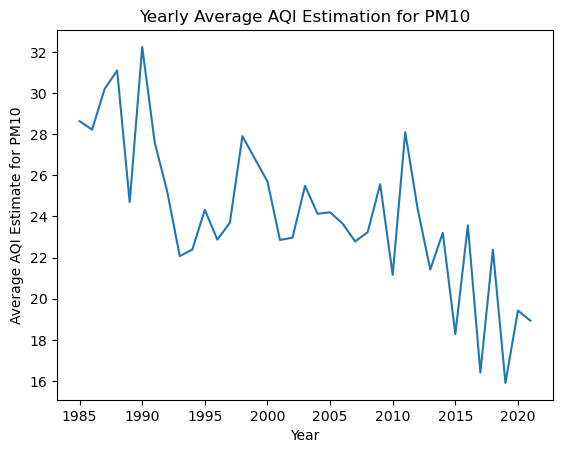

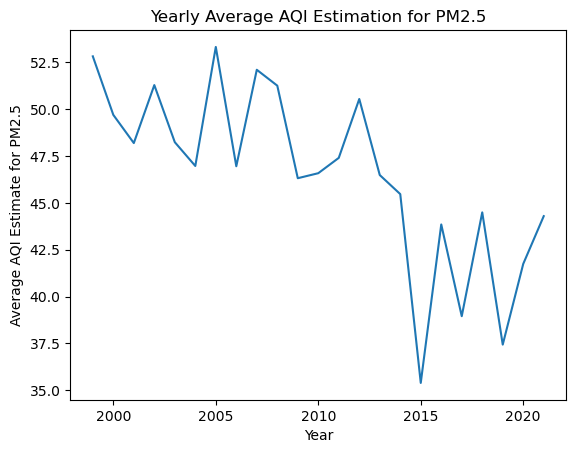

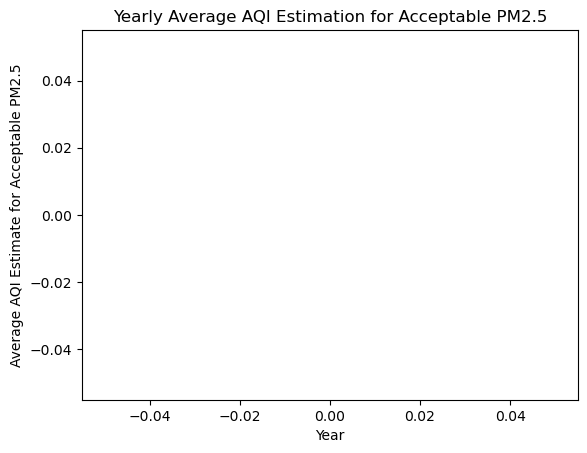

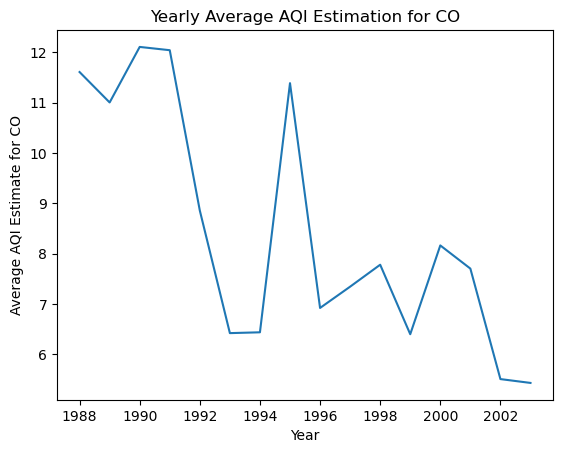

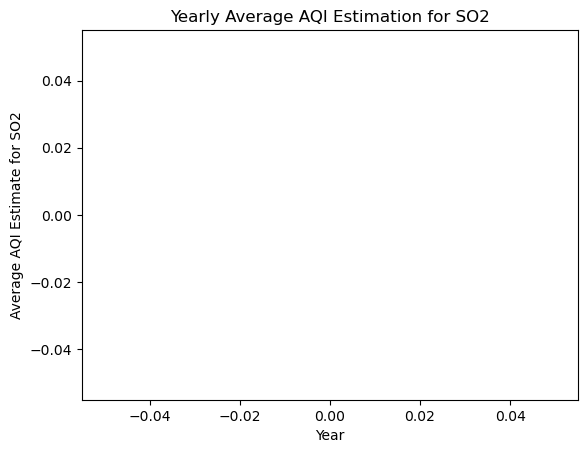

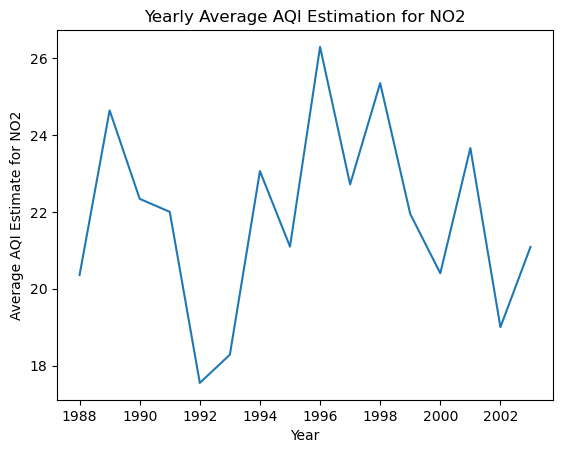

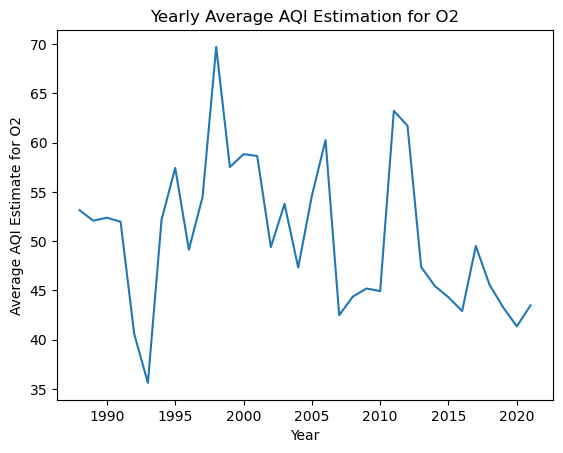

In [ ]:
#Exploratory plotting of the smoke estimate for all of the different pollutants individually
pollutant_names = ['PM10', 'PM2.5', 'Acceptable PM2.5', 'CO', 'SO2', 'NO2', 'O2']
for i, pollutant in enumerate(POLLUTANTS_Particulate + POLLUTANTS_Gaseous):
    yearly_average_aqi_df = pd.DataFrame.from_dict(yearly_average_aqi[pollutant], orient='index', columns=['Average_AQI_Estimate']).reset_index().rename(columns={'index':'Year'})

    plt.plot(yearly_average_aqi_df['Year'], yearly_average_aqi_df['Average_AQI_Estimate'])
    plt.title(f"Yearly Average AQI Estimation for {pollutant_names[i]}")
    plt.xlabel("Year")
    plt.ylabel(f"Average AQI Estimate for {pollutant_names[i]}")
    plt.show()

To obtain an estimate for overall AQI, we will use the max of the average of the recorded measurements across all pollutant types (a much simplified interpretation of the [formula](https://www.airnow.gov/publications/air-quality-index/technical-assistance-document-for-reporting-the-daily-aqi/) provided by AirNow.gov ) but will help to give us an overall sense of AQI over time.


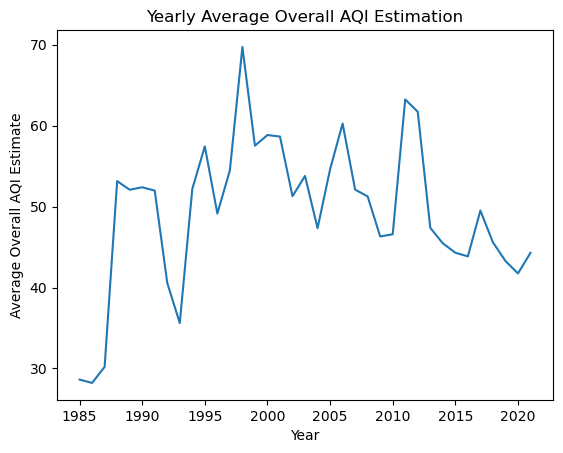

In [16]:
# Convert the JSON data to a DataFrame
yearly_average_aqi_df = pd.DataFrame.from_dict(yearly_average_aqi, orient='columns')
#yearly_average_aqi_df = yearly_average_aqi_df[["88101", "81102", "44201"]]#Select the three metrics
yearly_average_aqi_df['Average_AQI_Estimate'] = yearly_average_aqi_df.max(axis=1)
yearly_average_aqi_df = yearly_average_aqi_df.reset_index().rename(columns={'index': 'Year'})
full_year_average = yearly_average_aqi_df[['Year', 'Average_AQI_Estimate']].sort_values( by = 'Year')

plt.plot(full_year_average['Year'], full_year_average['Average_AQI_Estimate'])
plt.title(f"Yearly Average Overall AQI Estimation")
plt.xlabel("Year")
plt.ylabel(f"Average Overall AQI Estimate")
plt.show()

In [ ]:
#Store the final aqi estimates to our data clean folder
full_year_average.to_csv("../data_clean/norman_aqi_yearly_average.csv")